In [1]:
import kwant
import tbmodels
import wraparound
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import pyplot
import csv
import math

C:\Users\Me\Anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)
C:\Users\Me\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Sample model for visualizing neighbour connections

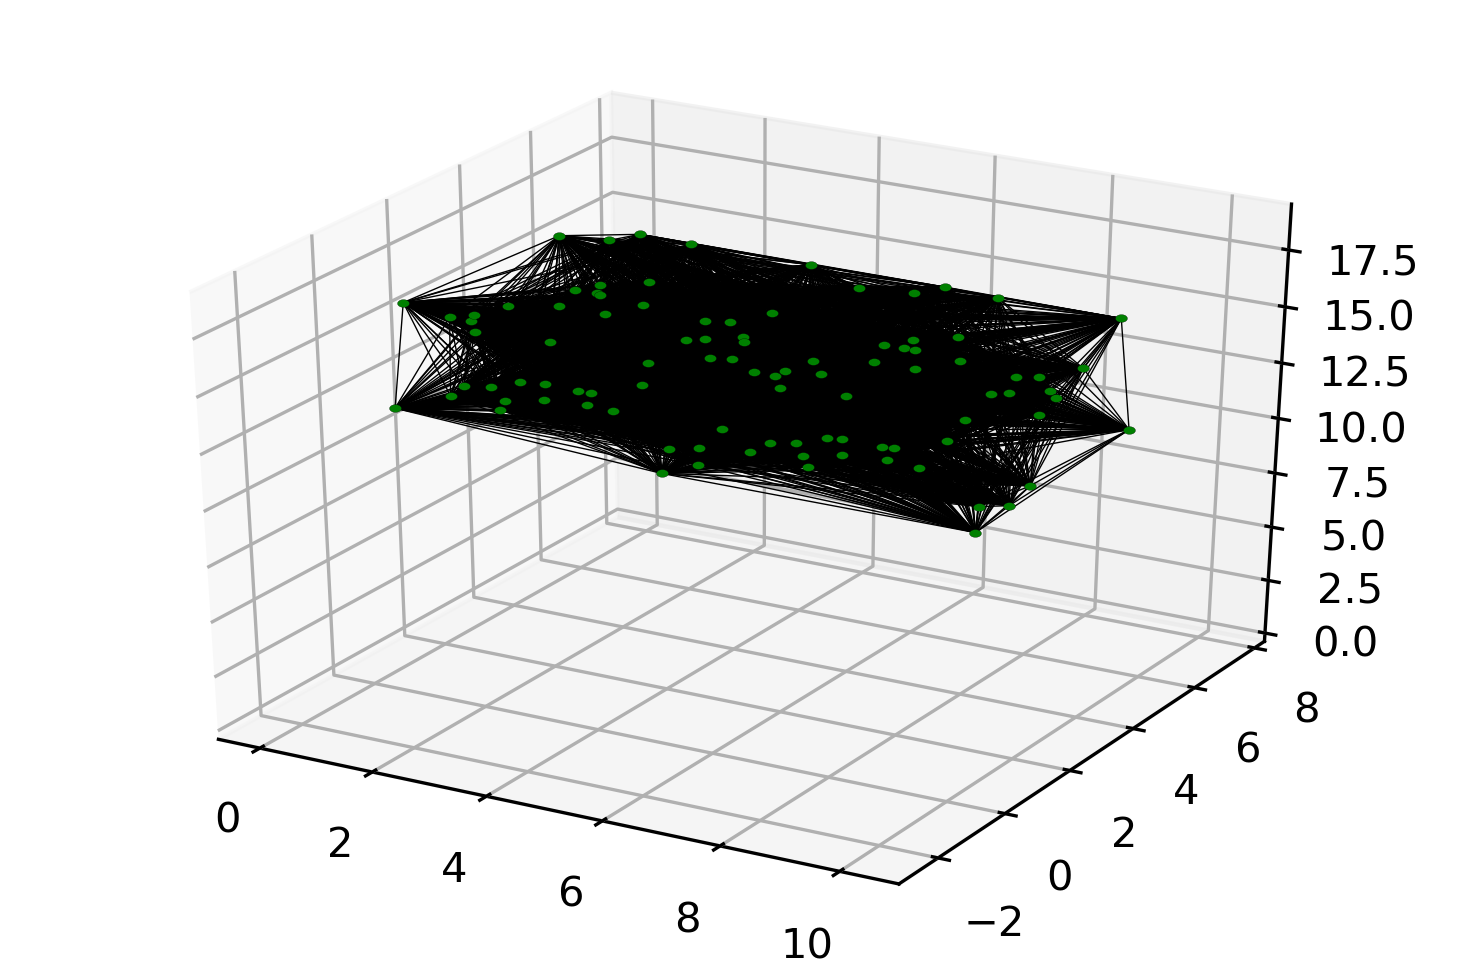

In [2]:
model = tbmodels.Model.from_wannier_files(
	hr_file='BiPentaSi_hr.dat',
	wsvec_file='BiPentaSi_wsvec.dat',
	xyz_file='BiPentaSi_centres.xyz',
	win_file='BiPentaSi.win'
)

nn = 2

remove = [R for R in model.hop if (R[0] > nn) or (R[1] > nn) or (R[2] > nn)]
for R in remove: 
  del model.hop[R]

remove = [R for R in model.hop if (R[0] < -nn) or (R[1] < -nn) or (R[2] < -nn)]
for R in remove: 
  del model.hop[R]

lattice = model.to_kwant_lattice()

def lead_shape(p):
	x, y, z = p
	return -2*model.uc[0][0] < x < 2*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30
	
	
sym_lead = kwant.TranslationalSymmetry(
    lattice.vec((2, 0, 0)),
    lattice.vec((0, 1, 0)),
	lattice.vec((0, 0, 1))
)

lead = kwant.Builder(sym_lead)
lead[lattice.shape(lead_shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(lead)

kwant_sys = wraparound.wraparound(lead).finalized()
fig = kwant.plot(kwant_sys, site_size=0.18, site_lw=0.01, hop_lw=0.05, site_color='g', dpi = 300)

# Dispersion curve for 1x1 unit cell in the XM direction

(-3, 3)

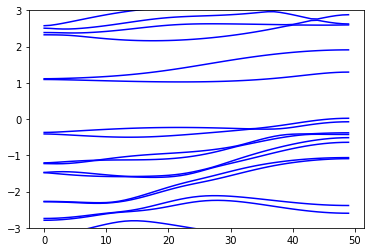

In [3]:
lattice = model.to_kwant_lattice()

def lead_shape(p):
	x, y, z = p
	return -1*model.uc[0][0] < x < 1*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30
	
	
sym_lead = kwant.TranslationalSymmetry(
    lattice.vec((1, 0, 0)),
    lattice.vec((0, 1, 0)),
	lattice.vec((0, 0, 1))
)

lead = kwant.Builder(sym_lead)
lead[lattice.shape(lead_shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(lead)

kwant_sys = wraparound.wraparound(lead).finalized()

Ef = -1.784
k_list = [(kx, 0.5, 0) for kx in np.linspace(0, 0.5, 50)]
kx = range(50)
eigs_kwant = [la.eigvalsh(
    kwant_sys.hamiltonian_submatrix(2 * np.pi * np.array(k))
) for k in k_list]
fig, ax = plt.subplots()
for band in np.array(eigs_kwant).T:
    ax.plot(kx, band-Ef, 'b')
plt.ylim(-3,3)

# 6x2 model for transport calculations

Model for nn= 2 created
Lead for nn= 2 created


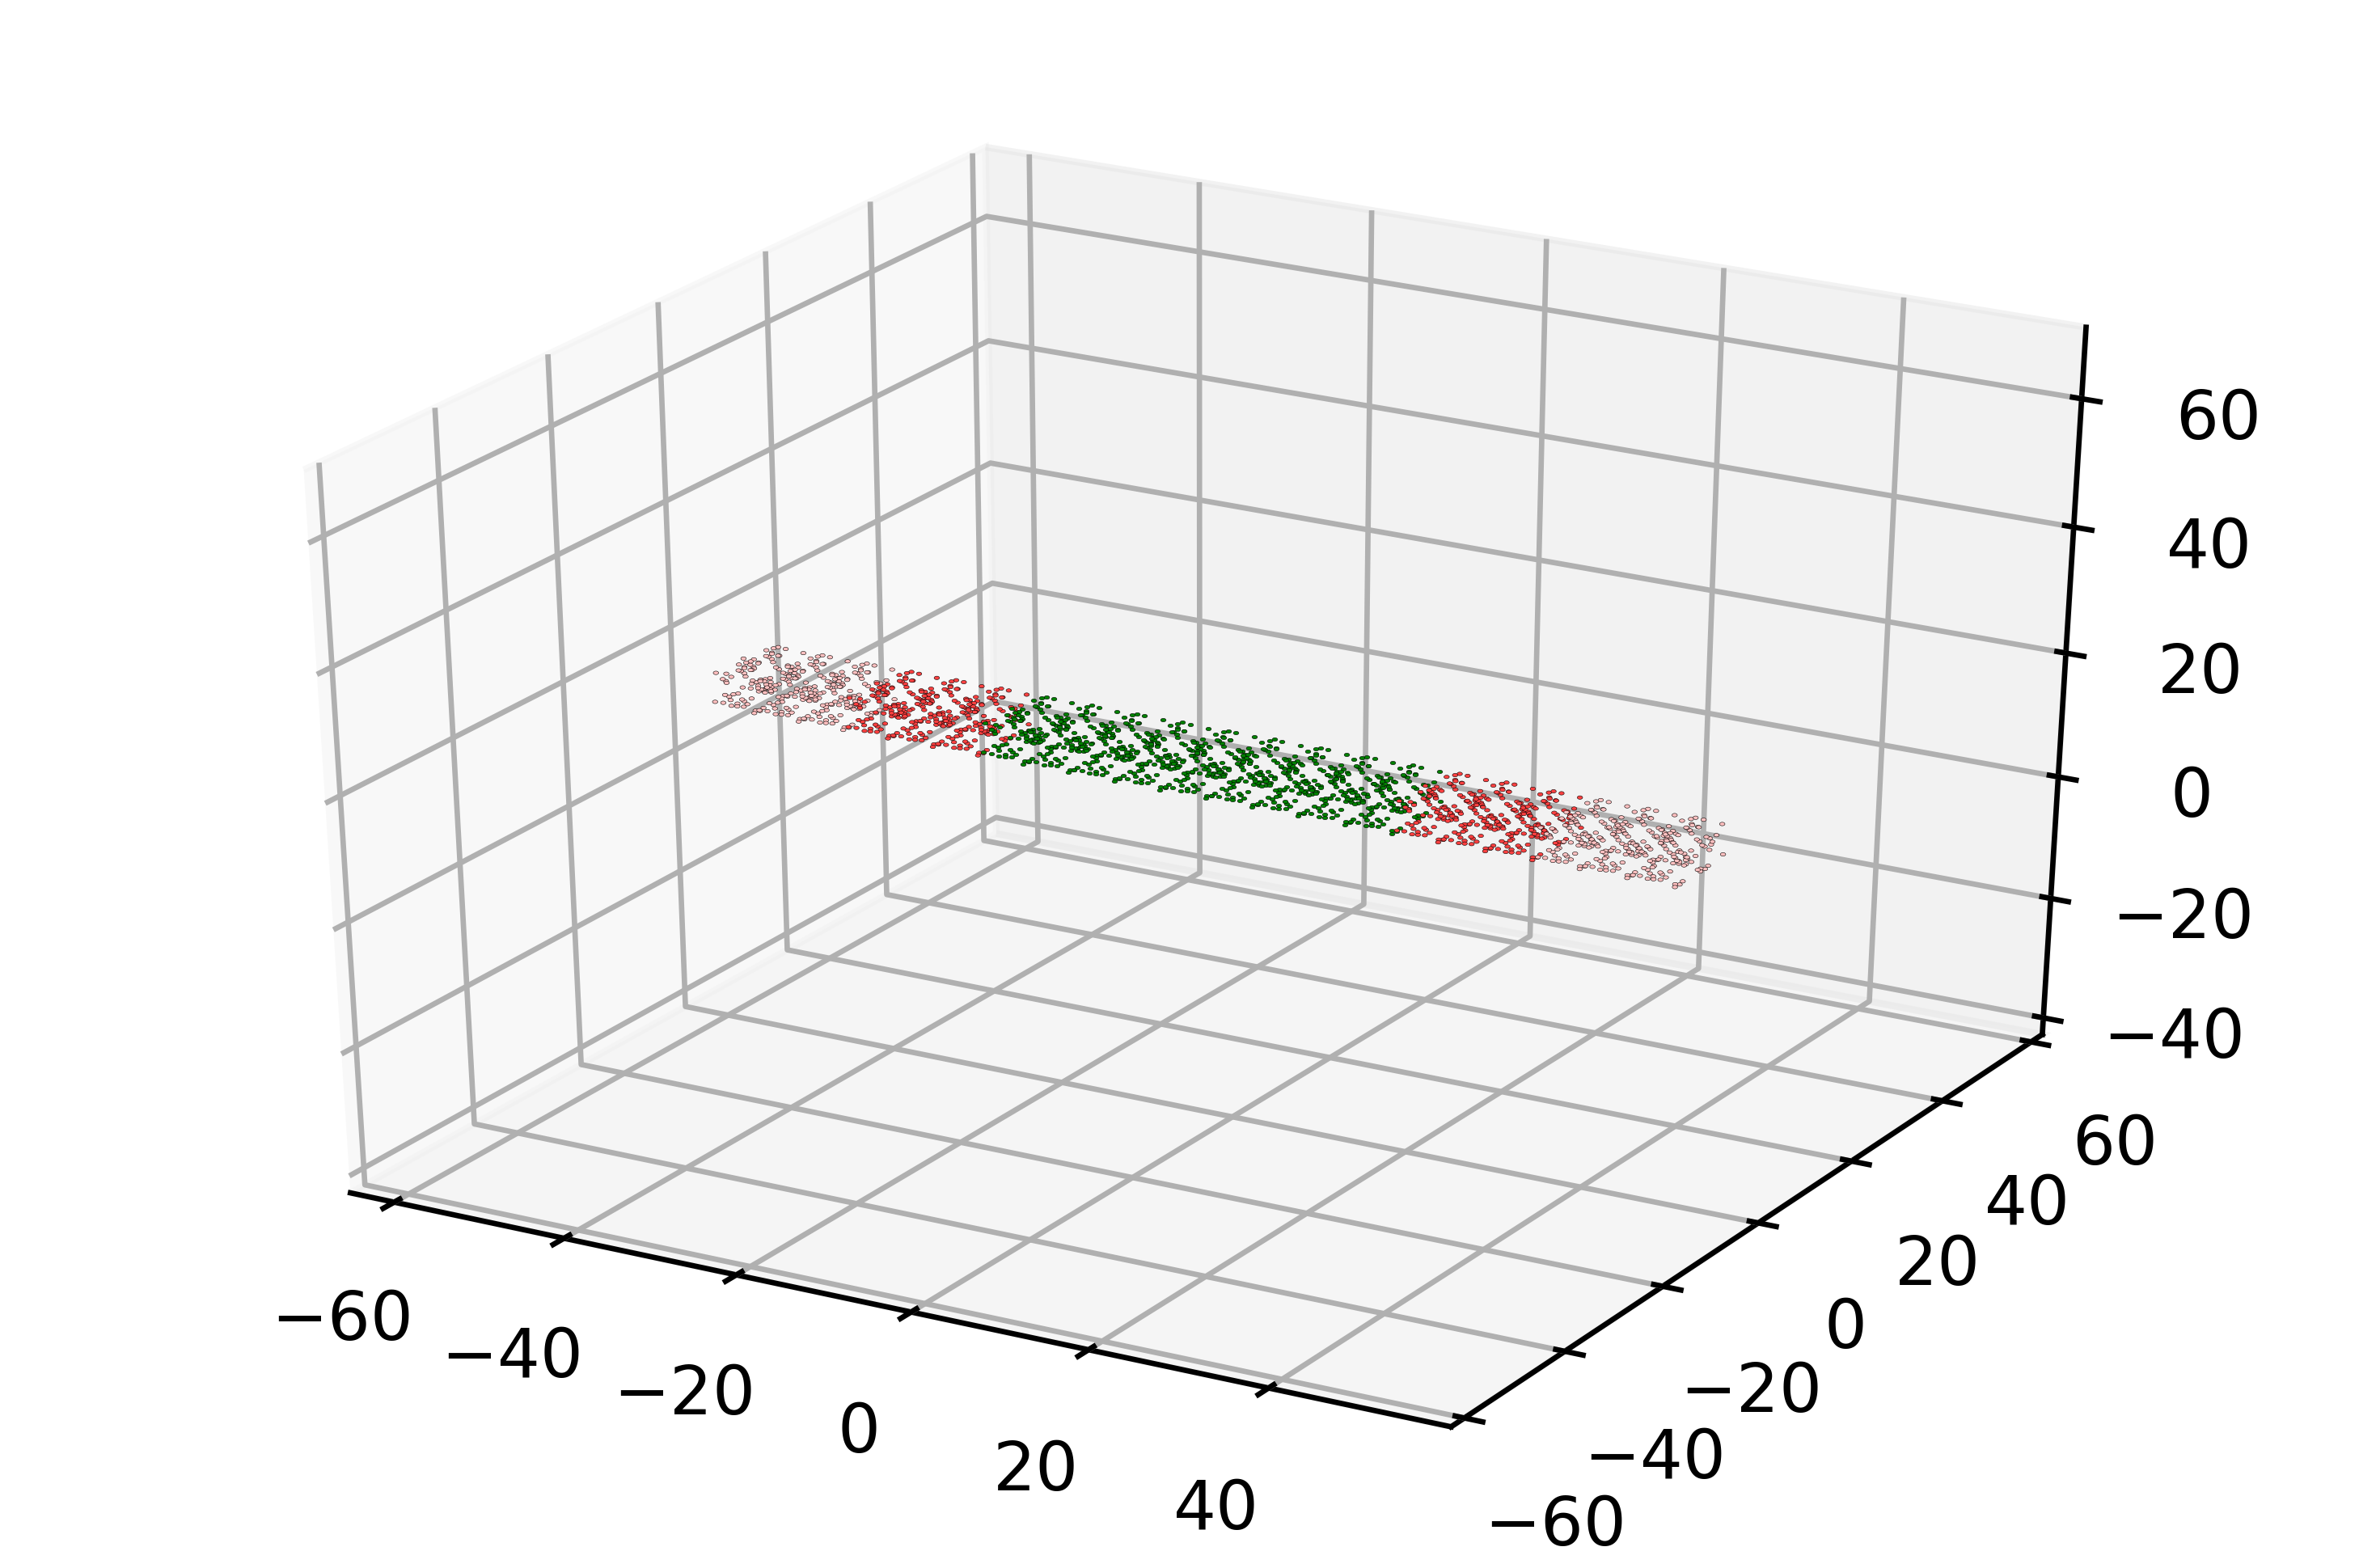

In [4]:
def shape(p):
	x, y, z = p
	return -3*model.uc[0][0] < x < 3*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30

def lead_shape(p):
	x, y, z = p
	return -3*model.uc[0][0] < x < 1*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30

remove = [R for R in model.hop if (R[0] > nn) or (R[1] > nn) or (R[2] > nn)]
for R in remove: 
  del model.hop[R]

remove = [R for R in model.hop if (R[0] < -nn) or (R[1] < -nn) or (R[2] < -nn)]
for R in remove: 
  del model.hop[R]

lattice = model.to_kwant_lattice()

kwant_model = kwant.Builder()
kwant_model[lattice.shape(shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(kwant_model)

print("Model for nn=",nn,"created")

#1D translational symmetry
sym_lead = kwant.TranslationalSymmetry(
    lattice.vec((-3, 0, 0))
)
lead = kwant.Builder(sym_lead)
lead[lattice.shape(lead_shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(lead)

print("Lead for nn=",nn,"created")

#Add the norbs in the system for plotting of local quantities (current, electron density)
for x in kwant_model.sites():
 x.family.norbs=1

for x in lead.sites():
  x.family.norbs=1

kwant_model.attach_lead(lead)
kwant_model.attach_lead(lead.reversed())
kwant_sys = kwant_model.finalized()

kwant.plot(kwant_sys, site_size=0.5, site_color='g', file='wire-Xdirection.png', dpi = 600)

In [5]:
energies = [i+(Ef-1) for i in np.linspace(0,2,100)]
data = []
for energy in energies:
  print(energy)
  # compute the scattering matrix at a given energy
  try:
    smatrix = kwant.smatrix(kwant_sys, energy)
    data.append(smatrix.transmission(1, 0))
  except RuntimeError:
   print("Error")
   continue

-2.784
-2.7637979797979795
-2.7435959595959596
-2.7233939393939393
-2.703191919191919
-2.6829898989898986
-2.6627878787878787
-2.6425858585858584
-2.622383838383838
-2.602181818181818
-2.581979797979798
-2.5617777777777775
-2.5415757575757576
-2.5213737373737373
-2.501171717171717
-2.4809696969696966
-2.4607676767676767
-2.4405656565656564
-2.420363636363636
-2.4001616161616157
-2.379959595959596
-2.3597575757575755
-2.339555555555555
-2.3193535353535353
-2.299151515151515
-2.2789494949494946
-2.2587474747474747
-2.2385454545454544
-2.218343434343434
-2.198141414141414
-2.177939393939394
-2.1577373737373735
-2.137535353535353
-2.117333333333333
-2.097131313131313
-2.0769292929292926
-2.0567272727272723
-2.0365252525252524
-2.016323232323232
-1.9961212121212117
-1.9759191919191916
-1.9557171717171715
-1.9355151515151512
-1.915313131313131
-1.895111111111111
-1.8749090909090906
-1.8547070707070703
-1.8345050505050502
-1.81430303030303
-1.7941010101010098
-1.7738989898989896
-1.7536969696

# Plotting conductance

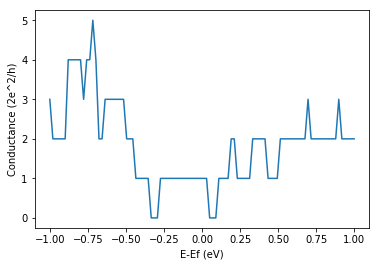

In [6]:
pyplot.figure()
energies = np.array(energies)
pyplot.plot(energies-Ef, data)
pyplot.xlabel("E-Ef (eV)")
pyplot.ylabel("Conductance (2e^2/h)")
pyplot.show()

# Calculating local current density

In [7]:
for x in kwant_model.sites():
  x.family.norbs=1

for x in lead.sites():
  x.family.norbs=1

kwant_model.attach_lead(lead)
kwant_model.attach_lead(lead.reversed())
kwant_sys = kwant_model.finalized()

energy = Ef-0.1919
#-1.97591919
psi = kwant.wave_function(kwant_sys, energy=energy)
J = kwant.operator.Current(kwant_sys)
all_states = np.vstack(psi(0))
current = sum(J(p) for p in all_states)
curr_i = kwant.plotter.interpolate_current(kwant_sys,current)

1


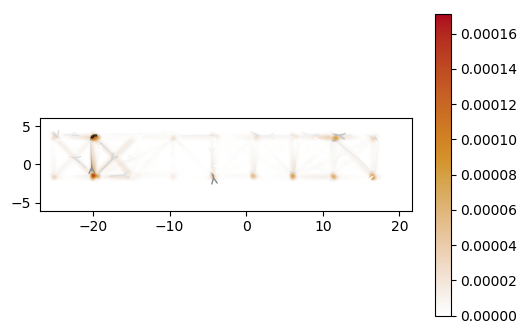

2


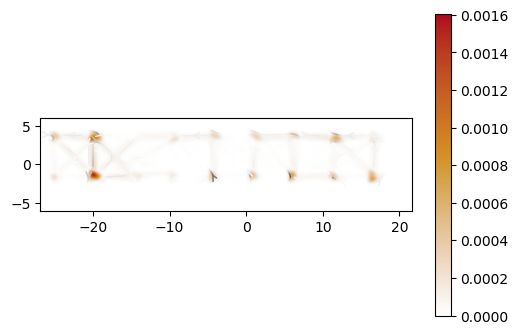

3


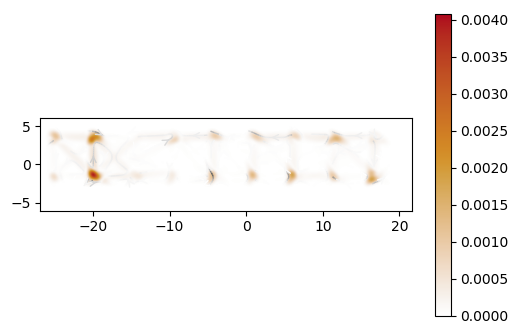

4


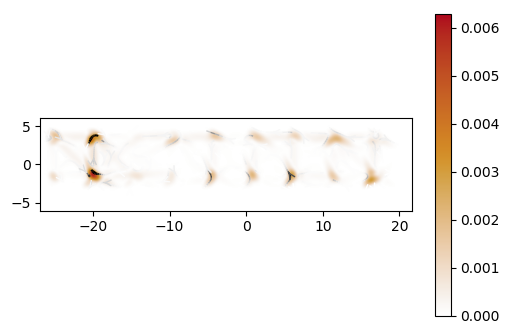

5


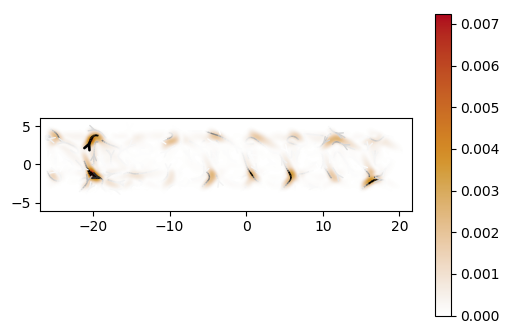

6


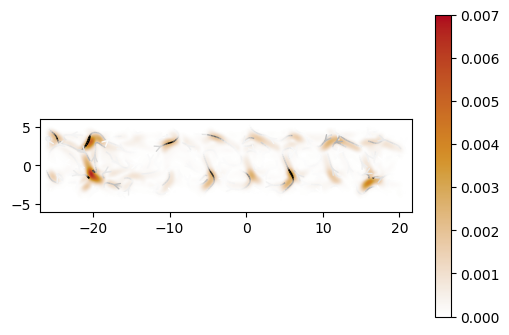

7


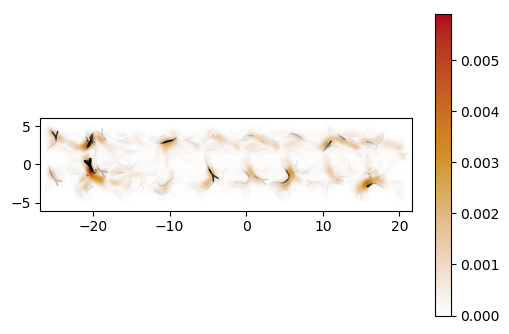

8


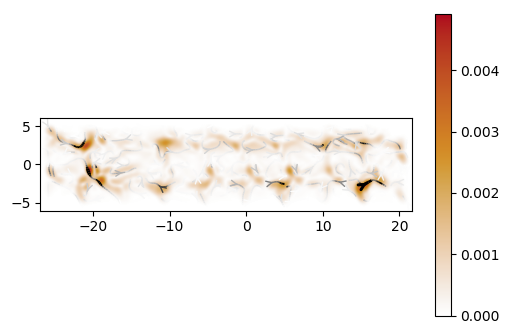

9


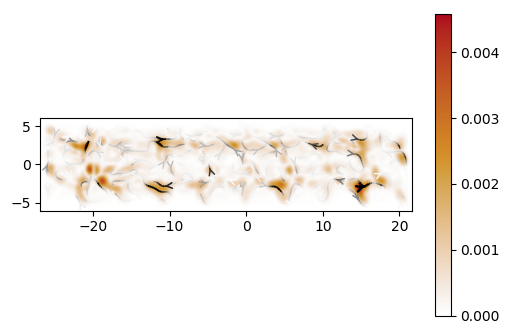

10


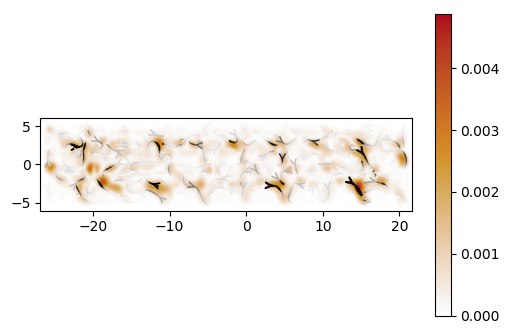

11


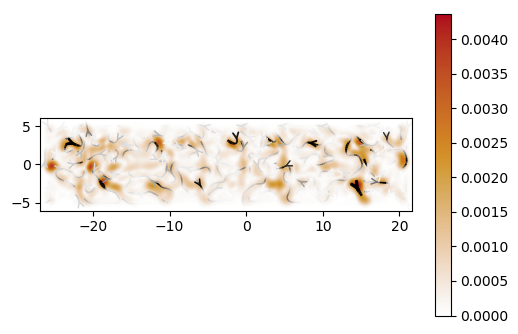

12


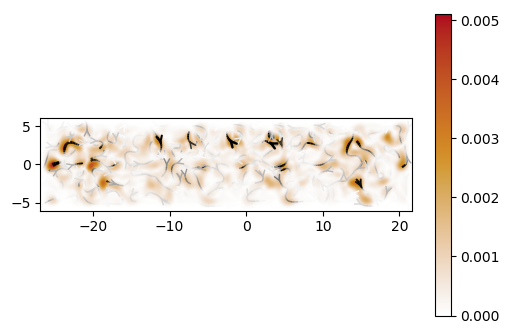

13


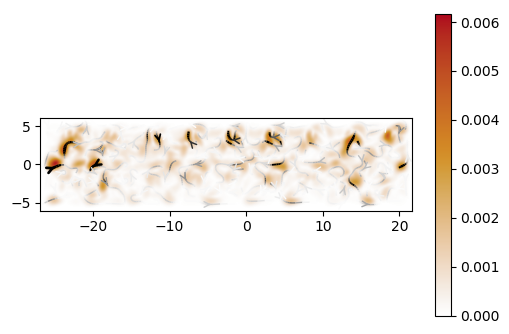

14


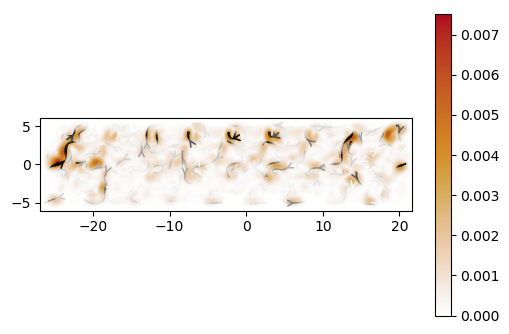

15


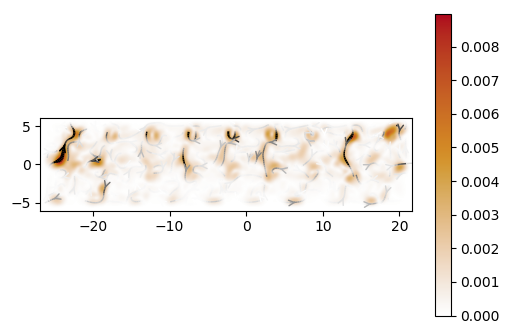

16


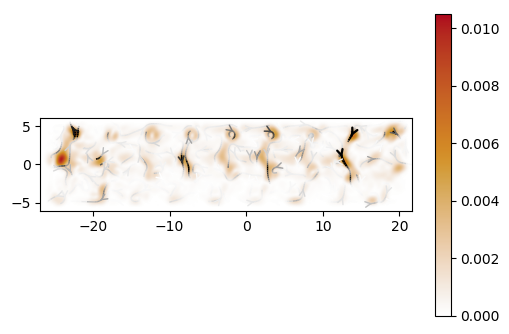

17


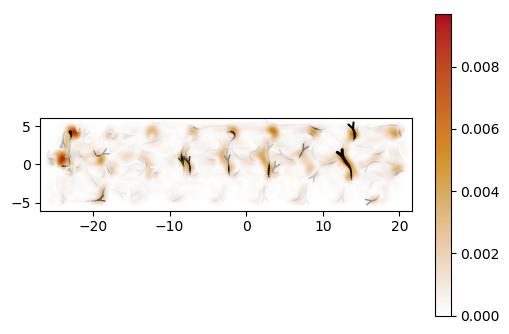

18


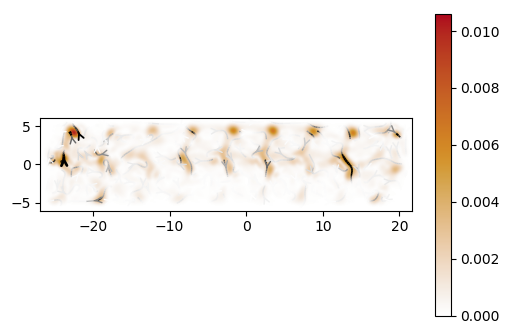

19


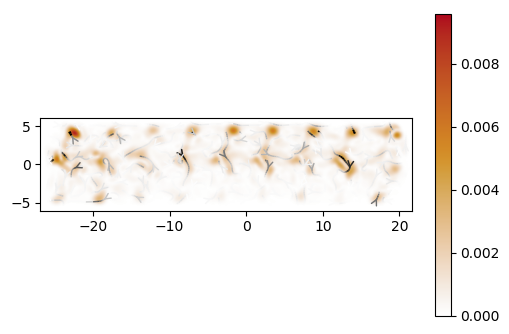

20


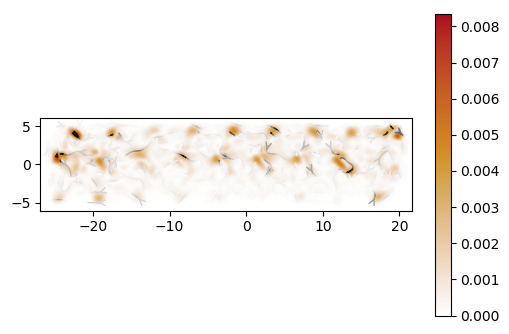

21


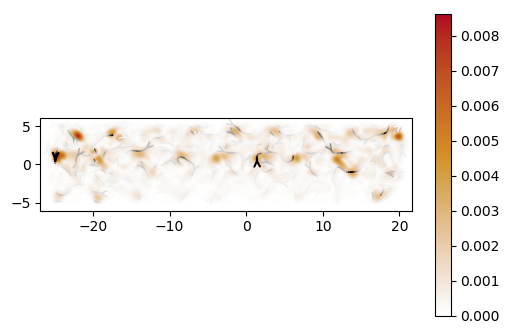

22


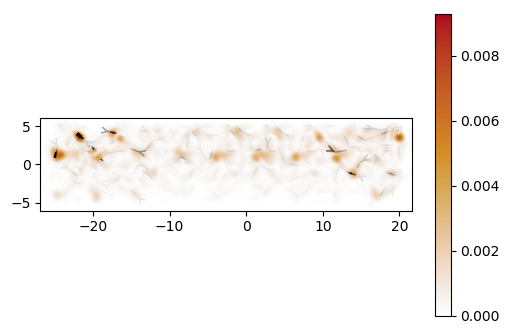

23


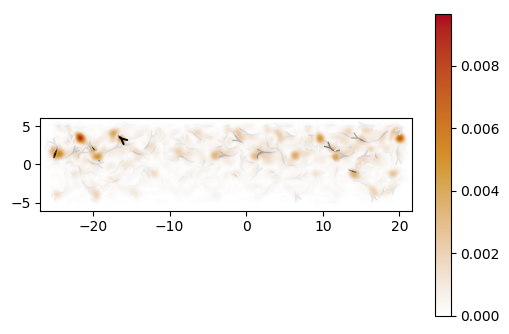

24


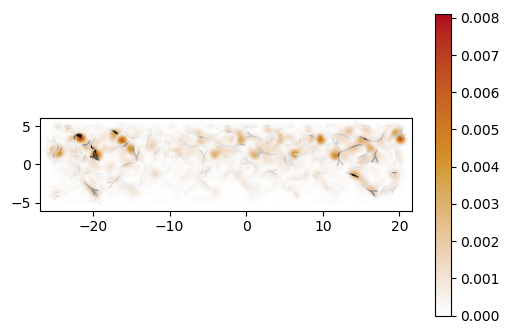

25


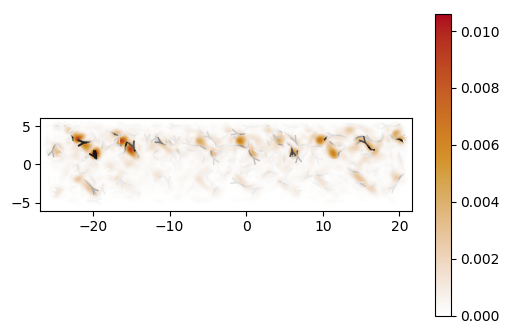

26


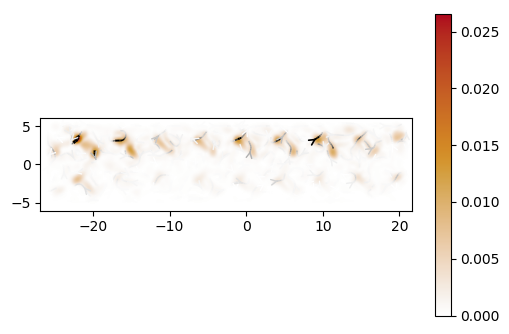

27


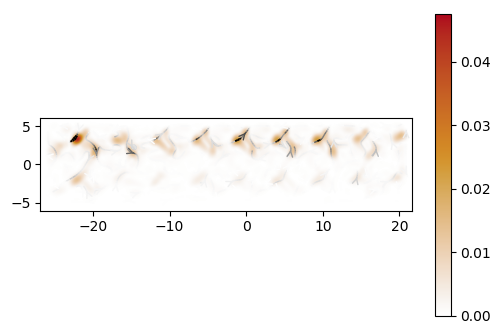

28


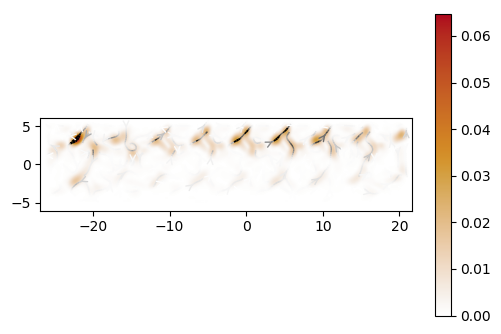

29


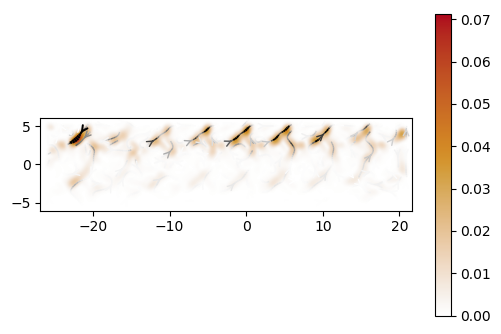

30


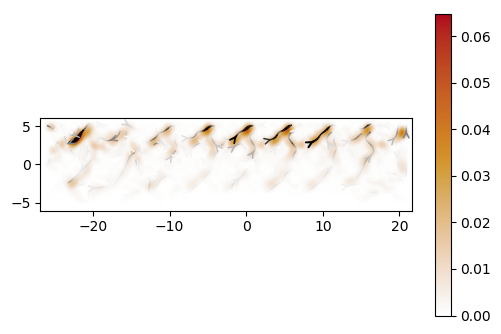

31


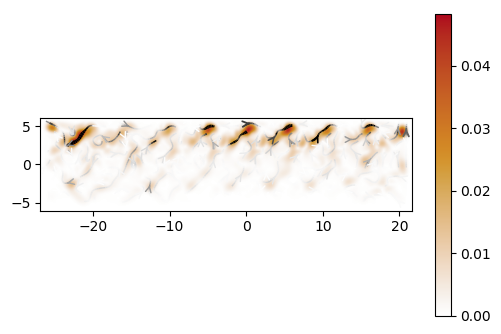

32


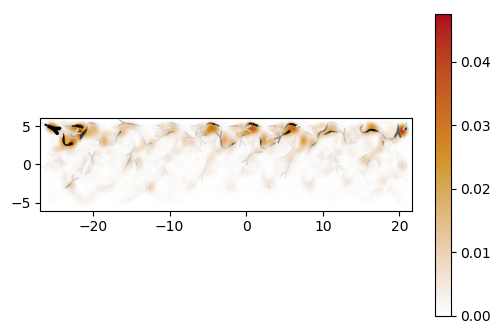

33


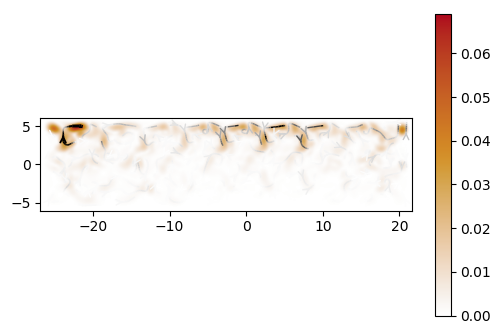

34


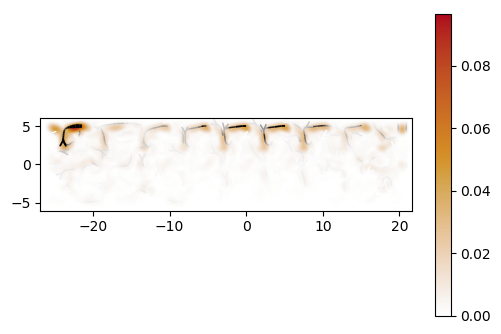

35


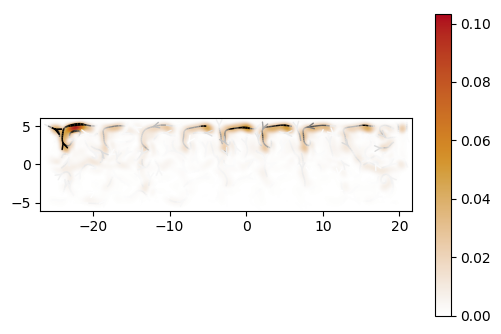

36


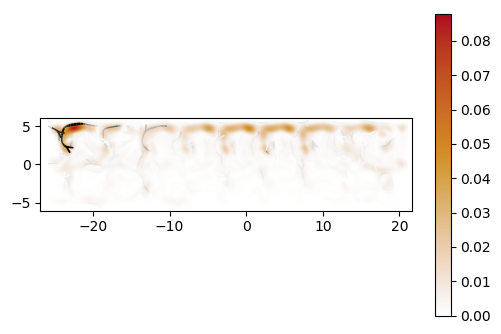

37


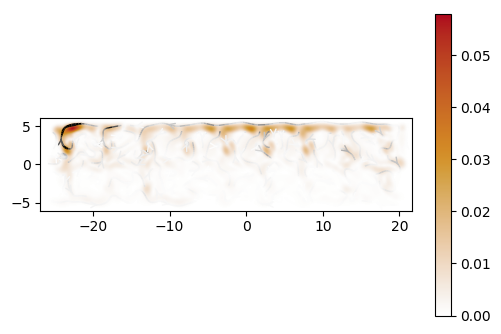

38


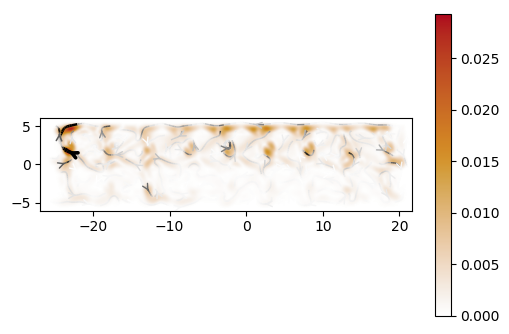

39


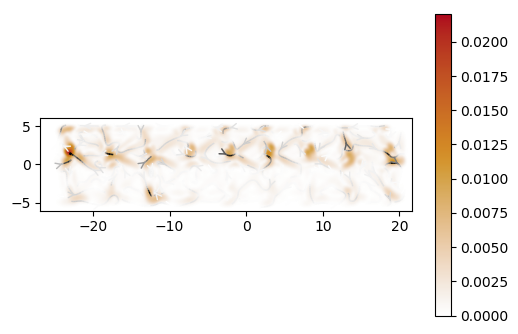

40


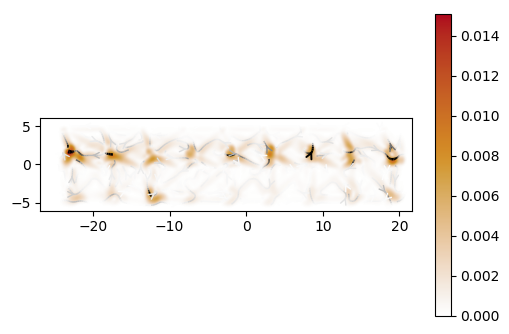

41


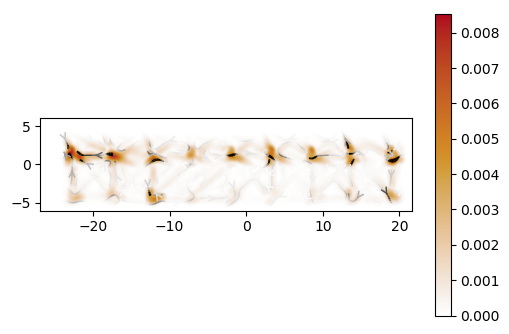

42


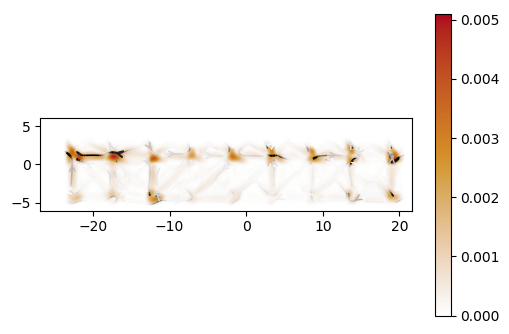

43


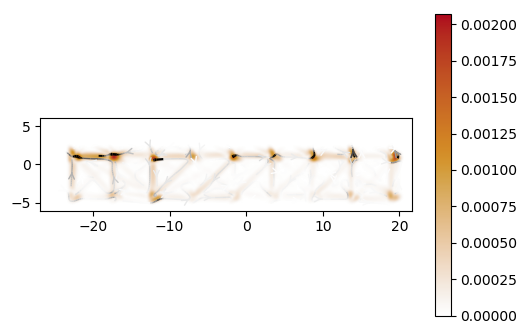

44


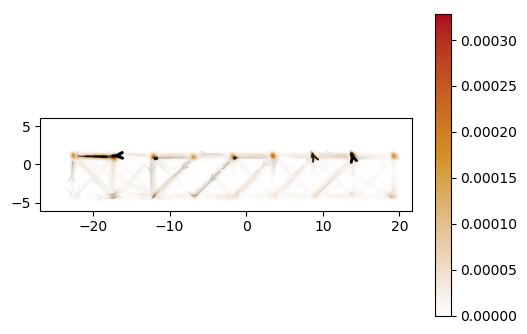

In [8]:
for zcut in range(1,45):
  print(zcut)
  kwant.plotter.streamplot(curr_i[0][:,:,zcut,:2], (curr_i[1][0],curr_i[1][1]),dpi=100)

# The z cuts extend over the following range

In [9]:
print(curr_i[1][2])

(9.103848992663176, 19.064198467336823)


# Number of slices in the z direction

In [10]:
print(len(curr_i[0][0][0]))

46


# z position of each slice

In [11]:
np.linspace(9.103848992663176,19.064198467336823,46)

array([ 9.10384899,  9.32519009,  9.54653119,  9.76787229,  9.98921339,
       10.21055449, 10.43189559, 10.65323669, 10.87457779, 11.09591889,
       11.31725999, 11.53860109, 11.75994219, 11.98128329, 12.20262438,
       12.42396548, 12.64530658, 12.86664768, 13.08798878, 13.30932988,
       13.53067098, 13.75201208, 13.97335318, 14.19469428, 14.41603538,
       14.63737648, 14.85871758, 15.08005868, 15.30139978, 15.52274088,
       15.74408198, 15.96542308, 16.18676417, 16.40810527, 16.62944637,
       16.85078747, 17.07212857, 17.29346967, 17.51481077, 17.73615187,
       17.95749297, 18.17883407, 18.40017517, 18.62151627, 18.84285737,
       19.06419847])

# z positions of 48 sites

In [12]:
z = np.array([])
z1 = 0
for i in kwant_sys.sites:
  if(z1!=i.pos[2]):
    z1 = i.pos[2]
    z = np.append(z,[i.pos[2]], axis=0)
    z1 = i.pos[2]
print(z)

[11.13973602 11.47816678 12.07804006 16.0369525  16.75609682 10.32138112
 15.30725501 10.22661698 14.80150655 10.09193696 14.80101737 15.52143698
 13.37045655 12.79704588 10.21036887 17.03992339 17.10181068 13.36634378
 17.15200383 12.77184698 11.50137972 12.00671369 16.0841615  16.74419338
 11.43920778 17.04316689 16.06206763 12.08574173 12.79130478 13.32737585
 16.70156658 17.85099014 17.94130277 18.0761105  13.39900125 12.79336758
 15.3141887  14.84657687 17.94038987 11.14116463 11.07735722 11.00006866
 16.11470047 14.7978113  16.71277351 15.5033726  11.48019518 12.05715018]
